- Baixar dados: https://mapainterativo.cemaden.gov.br/#

- Informações sobre as estações: http://ped.cemaden.gov.br/ConsultarRedeEstacoes


# **1° Passo:** Importando bibliotecas

In [18]:
import time
import pandas as pd
import glob
import salem
import proplot as pplt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")

# **2° Passo:** Declarando funções

In [19]:
#-----------------------------------------------------------------------------------
# Função que plota as siglas
#-----------------------------------------------------------------------------------
def plot_siglas_statesb():
    color = 'gray'
    ax.annotate('RS', xy=(-55.0, -29.0),fontsize=15, color='black')
    ax.annotate('SC', xy=(-51.2, -27.5), fontsize=15, color='black')
    ax.annotate('Atlantic Ocean', xy=(-51.5, -33.0), fontsize=12, color=color)
    ax.annotate('Uruguay', xy=(-57.5, -32.5), fontsize=15, color=color)
    ax.annotate('Argentina', xy=(-57.6, -27.1), fontsize=15, color=color)
    ax.annotate('Paraguay', xy=(-57.4, -28.6), fontsize=15, color=color)

#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label, linestyle):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                aneis (lista): tamanho do raio do círculo em km
                lon_r (float): valor da longitude do centro do círculo em graus
                lat_r (float): valor da latitude do centro do círculo em graus
                color (str): cor do raio do círculo
                label (str): legenda

    Parâmetros de saída:
                latitude e longitude que delimita círculos de distância centrado no radar e plota os círculos
    """

    import geopy
    from geopy import distance

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, linestyle=linestyle)

#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral_painel(aneis, lon_r, lat_r, color, label, linestyle, axx, lww):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                aneis (lista): tamanho do raio do círculo em km
                lon_r (float): valor da longitude do centro do círculo em graus
                lat_r (float): valor da latitude do centro do círculo em graus
                color (str): cor do raio do círculo
                label (str): legenda

    Parâmetros de saída:
                latitude e longitude que delimita círculos de distância centrado no radar e plota os círculos
    """

    import geopy
    from geopy import distance

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax[axx].plot(lons[i,:], lats[i,:], color=color, label= label, linestyle=linestyle, lw=lww)

# **PARTE 1):** Processamento

## Estações Pluviômétricas

In [20]:
%%time
#==========================================================================#
#                          JUNTA AS TABELAS
#==========================================================================#
# lista os arquivos
files = glob.glob('dados_estacoes/estacoes_CEMADEN_RS*csv')

# leitura dos arquivos
df = pd.DataFrame()
for file in files:

    # leitura da tabela
    df0 = pd.read_csv(file, delimiter=';', decimal=',')

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df, df0], ignore_index=True)

# renomeia os nomes das colunas
df = df.rename(columns={'valorMedida': 'chuva',
                        'datahora': 'data',
                        'nomeEstacao':'nome_estacao',
                        'latitude': 'lat',
                        'longitude':'lon'})

# insere a coluna data como DateTime no DataFrame
df['data'] = pd.to_datetime(df['data'])

# seta a coluna data com o index do dataframe
df.set_index('data', inplace=True)

# seleciona o período do evento
df_evento = df.loc['2024-04-26':'2024-05-05']

#==========================================================================#
#                      SELECTIONA AS TOP30 ESTAÇÕES
#==========================================================================#
# soma a chuva e seleciona as estações que possuem os maiores valores de acumulados
# de chuva entre 26/abril a 05/maio
acum = df_evento.groupby('codEstacao').sum()['chuva'].sort_values(ascending=False)[0:30]

codigo_estacoes_top30 = acum.index
valores_chuva_top30 = acum.values

# salva um arquivo com as top30 estações
df_top30 = pd.DataFrame()
codigo_estacao, municipio_estacao, nome_estacao, lat_estacao, lon_estacao, totalchuva_estacao = [], [], [], [], [], []

for codigo, chuva in zip(codigo_estacoes_top30, valores_chuva_top30):

    dfx = df[ df['codEstacao'] == codigo]

    # junta a tabela que foi lida com a anterior
    df_top30 = pd.concat([df_top30, dfx], ignore_index=False)

    # salva a lat e lon e nome da estação
    codigo_estacao.append(codigo)    
    municipio_estacao.append(dfx['municipio'][0])
    nome_estacao.append(dfx['nome_estacao'][0])
    lat_estacao.append(dfx['lat'][0])
    lon_estacao.append(dfx['lon'][0])
    totalchuva_estacao.append(chuva)

# salva aquivo CSV das top30 estações
df_top30.to_csv('dados_estacoes/top30_estacoes_CEMADEN_RS.csv')

# salva tabela com a localização das estações
df_localizacao = pd.DataFrame({'codigo': codigo_estacao,
                               'municipio': municipio_estacao,
                               'nome_estacao': nome_estacao,
                               'lat_estacao': lat_estacao,
                               'lon_estacao': lon_estacao,
                               'chuva_mm': totalchuva_estacao})

# copia o dataframe original 
df_localizacao2 = df_localizacao.copy()

# elimina linhas duplicadas e mantem a primeira ocorrência
df_localizacao2.drop_duplicates(subset=['municipio'], keep='first', inplace=True)

# salva tabela 
df_localizacao_save_artigo = df_localizacao2.copy()
df_localizacao_save_artigo.drop(columns=['codigo'], inplace=True)
df_localizacao_save_artigo = df_localizacao_save_artigo.rename(columns={'municipio': 'City',
                                                                        'nome_estacao': 'Station Name',
                                                                        'lat_estacao': 'Latitude',
                                                                        'lon_estacao': 'Longitude',
                                                                        'chuva_mm':'Precipitation (mm)'})
df_localizacao_save_artigo['Latitude'] = df_localizacao_save_artigo['Latitude'].round(4)
df_localizacao_save_artigo['Longitude'] = df_localizacao_save_artigo['Longitude'].round(4)
df_localizacao_save_artigo['City'] = df_localizacao_save_artigo['City'].apply(lambda x: x.title())
df_localizacao_save_artigo.to_excel('dados_estacoes/localizacao_top30_estacoes_CEMADEN_RS_ARTIGO.xlsx')

# mostra a tabela
#display(df_localizacao2)
#display(df_localizacao_save_artigo)

CPU times: total: 4.94 s
Wall time: 5.29 s


## Desastres Naturais

In [21]:
# leitura da tabela
df_desastres = pd.read_excel('dados_desastres/Ocorrencias_RS_correto_modificada.xls', usecols=['ID','UF','Região','Município','Evento do Registro','Data Ocorrência','Latitude', 'Longitude'])

# renomeia os nomes das colunas
df_desastres.rename(columns={'UF':'uf', 
                             'Região': 'regiao',
                             'Município': 'municipio',
                             'Evento do Registro': 'tipologia',
                             'Data Ocorrência': 'data',
                             'Latitude': 'lat', 
                             'Longitude': 'lon'}, inplace=True)

# transforma a data em índice
df_desastres['data'] = pd.to_datetime(df_desastres['data'], format='%d/%m/%Y')
df_desastres.set_index('data', inplace=True)

# ordena pela data o dataframe
df_desastres.sort_index(ascending=True, inplace=True)

# seleciona o período do evento
df_desastres_26abril_05maio = df_desastres.loc['2024-04-26':'2024-05-05']

# elimina linhas duplicadas e mantem a primeira ocorrência
#df_desastres.drop_duplicates(subset=['ID'], keep='first', inplace=True)

# muda a tipologia
#condicao = df_desastres['tipologia']=='Inundação-Alagamento' ; df_desastres['tipologia'] = np.where(condicao, 'Inundação', df_desastres['tipologia'])
#condicao = df_desastres['tipologia']=='Inundação-Enxurrada-Alagamento' ; df_desastres['tipologia'] = np.where(condicao, 'Inundação', df_desastres['tipologia'])

# mostra os dados
print('Quantidade de Desastres antes do filtro =', df_desastres.shape[0])
print('Quantidade de Desastres depois do filtro =', df_desastres_26abril_05maio.shape[0])
print('--------------------------------------------------------------------------------------------')
display(df_desastres_26abril_05maio)

Quantidade de Desastres antes do filtro = 83
Quantidade de Desastres depois do filtro = 70
--------------------------------------------------------------------------------------------


,ID,uf,regiao,municipio,tipologia,lat,lon
data,,,,,,,
2024-04-27,26666,RS,SUL,NOVO HAMBURGO,Alagamento,-29.734974,-51.048997
2024-04-27,26666,RS,SUL,NOVO HAMBURGO,Inundação,-29.734974,-51.048997
2024-04-29,25667,RS,SUL,LAJEADO,Alagamento,-29.466260,-51.960633
2024-04-29,25667,RS,SUL,LAJEADO,Alagamento,-29.448268,-51.988679
2024-04-29,25668,RS,SUL,ENCANTADO,Deslizamento,-29.188734,-51.915250
...,...,...,...,...,...,...,...
2024-05-04,25725,RS,SUL,ITATI,Inundação,-29.509014,-50.091519
2024-05-04,25719,RS,SUL,PELOTAS,Inundação,-31.699600,-52.155855
2024-05-04,25718,RS,SUL,HORIZONTINA,Inundação,-27.590333,-54.299013


# **PARTE 2):** Plota mapa

## FIGURA FINAL

In [22]:
df_localizacao2

,codigo,municipio,nome_estacao,lat_estacao,lon_estacao,chuva_mm
0,432026301A,SEGREDO,Prefeitura,-29.339900,-52.982000,812.60
1,430830001A,FONTOURA XAVIER,Centro,-28.984850,-52.344450,778.00
2,431123901A,LAGOA BONITA DO SUL,Centro,-29.490000,-53.013000,749.20
3,430510802A,CAXIAS DO SUL,Forqueta,-29.214000,-51.282000,679.60
4,430420002A,CANDELÁRIA,Fábrica de Injetados,-29.662860,-52.787290,666.80
5,431310201A,NOVA PALMA,Centro,-29.470000,-53.465000,636.80
6,430800301A,FAXINAL DO SOTURNO,Centro,-29.580900,-53.446700,634.80
7,432080002A,SOLEDADE,Centro,-28.830164,-52.510442,624.80
8,430057001A,ALTO FELIZ,Alto Feliz,-29.382020,-51.317580,617.00
9,431140303A,LAJEADO,Moinhos D´Agua,-29.452000,-52.003000,589.40


definiu parâmetros
CPU times: total: 11.6 s
Wall time: 39.6 s


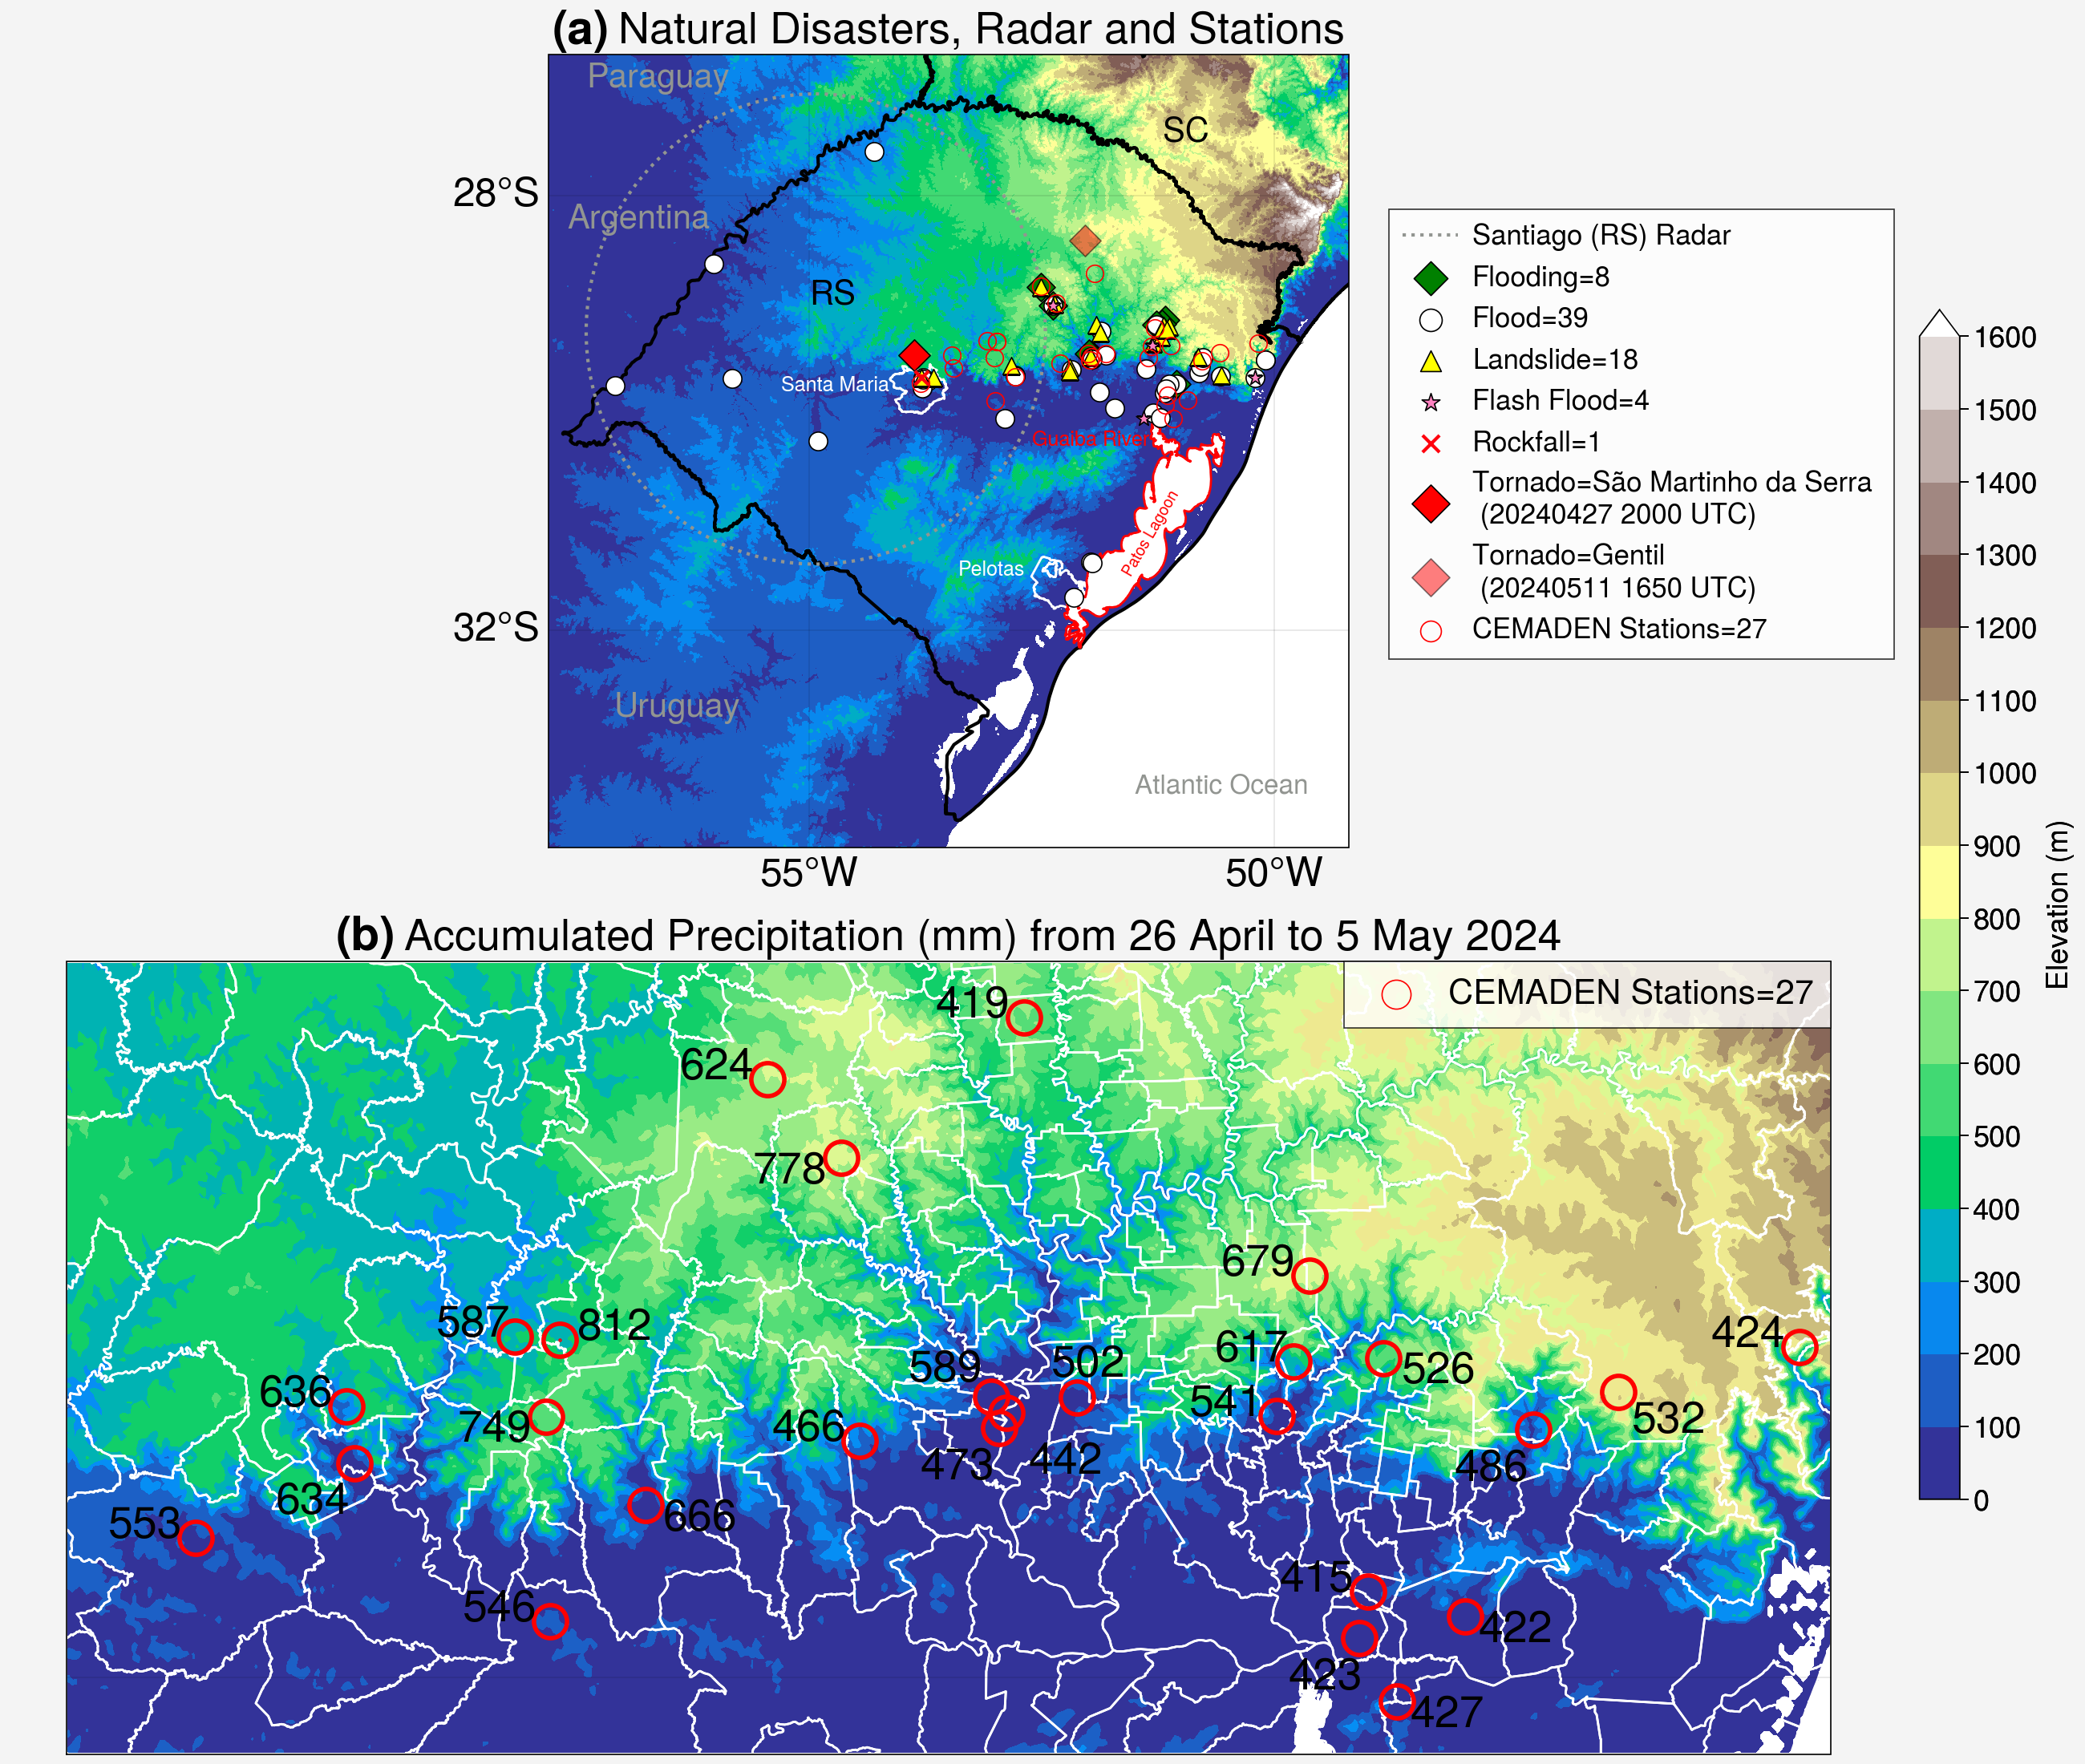

In [41]:
%%time
#========================================================================================================================#
#                                             PARÂMETROS DOS DESASTRES
#========================================================================================================================#
# lista dos desastres
desastres_portugues = list(df_desastres_26abril_05maio['tipologia'].unique())
desastres_ingles = ['Flooding', 'Flood', 'Landslide', 'Flash Flood', 'Rockfall']

# cores, símbolos e tamanho dos desastres
colors_desastres = ['green', 'white', 'yellow', 'pink', 'bright red' ]
simbols_desastres = ['D','o','^','*', 'x'] # https://matplotlib.org/stable/api/markers_api.html
size_desastres = [80, 70, 60, 50, 40]

#========================================================================================================================#
#                                             CARREGA SHAPEFILES
#========================================================================================================================#
# leitura dos estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')

# selecionando os contorno do RS
rs = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'RS')]

# selecionando os contornos dos Estados no mapa
estados_mapa = estados_brasil.loc[(estados_brasil['SIGLA_UF'] == 'RS') | (estados_brasil['SIGLA_UF'] == 'SC')]

# municípios
municipios_rs = salem.read_shapefile('https://github.com/evmpython/minicurso_nowcasting_CPAM2024/raw/main/shapefiles/RS_Municipios_2019.shp')

santa_maria = municipios_rs.loc[(municipios_rs['NM_MUN'] == 'Santa Maria')]
pelotas = municipios_rs.loc[(municipios_rs['NM_MUN'] == 'Pelotas')]
porto_alegre = municipios_rs.loc[(municipios_rs['NM_MUN'] == 'Porto Alegre')]
lagoa_patos = municipios_rs.loc[(municipios_rs['NM_MUN'] == 'Lagoa dos Patos')]
rio_guaiba = municipios_rs.loc[(municipios_rs['NM_MUN'] == 'Guaíba')]

#========================================================================================================================#
#                                             LIMITES DA REGIÃO
#========================================================================================================================#
lonmin, lonmax, latmin, latmax = -57.8, -49.2, -34.0, -26.7

#========================================================================================================================#
#                                           LEITURA DO DADO DE RELEVO
#========================================================================================================================#
# fontes do dado de relevo: https://catalog.data.gov/dataset/srtm30-global-1-km-digital-elevation-model-dem-version-11-land-surface
url = 'https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/srtm30plus_v11_land'
ds = xr.open_dataset(url).sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))

# moldura da figura
fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(13,11), tight=True, proj='pcarree', sharey=True, sharex=True)

# formatação dos eixos
ax.format(small='25px', large='27px', abc=True, abcstyle='(a)', abcsize=21, abcloc='c')
print('definiu parâmetros')

#========================================================================================================================#
#                                                   FIG-1
#========================================================================================================================#
#------------------------------------#
#            Relevo
#------------------------------------#
# formatação dos eixos da figura
ax[0].format(labels=True, 
             latlines=4, lonlines=5, 
             latlim=(latmin, latmax), lonlim=(lonmin, lonmax), 
             ctitle='Natural Disasters, Radar and Stations')

# plota figura
map1 = ax[0].contourf(ds['lon'],
                      ds['lat'],
                      ds['elev'][:,:],
                      cmap='terrain',
                      vmin=0, vmax=1600,
                      levels=pplt.arange(0, 1600, 100),
                      extend='max')

# Estados
estados_mapa.plot(edgecolor='black', facecolor='none', linewidth=1.5, alpha=1, ax=ax[0])

# Santa Maria
santa_maria.plot(edgecolor='white', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])
ax[0].annotate('Santa Maria', xy=(-55.3, -29.8), fontsize=9, color='white', rotation=0)

# Pelotas
pelotas.plot(edgecolor='white', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])
ax[0].annotate('Pelotas', xy=(-53.4, -31.5), fontsize=9, color='white', rotation=0)

# Lagoa dos Patos
lagoa_patos.plot(edgecolor='red', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])
ax[0].annotate('Patos Lagoon', xy=(-51.65, -31.5), fontsize=7, color='red', rotation=60)

# Nome Rio Guaíba
ax[0].annotate('Guaiba River', xy=(-52.6, -30.3), fontsize=9, color='red', rotation=0)

# plota sigla dos estados
color = 'gray'
ax[0].annotate('RS', xy=(-55.0, -29.0),fontsize=15, color='black')
ax[0].annotate('SC', xy=(-51.2, -27.5), fontsize=15, color='black')
ax[0].annotate('Atlantic Ocean', xy=(-51.5, -33.5), fontsize=12, color=color)
ax[0].annotate('Uruguay', xy=(-57.1, -32.8), fontsize=15, color=color)
ax[0].annotate('Argentina', xy=(-57.6, -28.3), fontsize=15, color=color)
ax[0].annotate('Paraguay', xy=(-57.4, -27.), fontsize=15, color=color)

# plota os aneis de distância do radar
#evm_plota_aneis_em_geral_painel([240], -49.47176413, -28.1285956, 'gray', label='Morro da Igreja (SC) Radar', linestyle='solid', axx=0, lww=0.5)
#evm_plota_aneis_em_geral_painel([240], -52.60374, -27.04879, 'gray', label='Chapecó (SC) Radar', linestyle='dotted', axx=0, lww=1.5)
#evm_plota_aneis_em_geral_painel([240], -52.7016774, -31.4039101, 'gray', label='Canguçu (RS) Radar', linestyle='solid', axx=0, lww=0.5)
evm_plota_aneis_em_geral_painel([240], -54.930064194, -29.22521647222, 'gray', label='Santiago (RS) Radar', linestyle='dotted', axx=0, lww=1.5)

#------------------------------------#
#            Desastres
#------------------------------------#
for desastre, simbolo, cor, size in zip(desastres_portugues, simbols_desastres, colors_desastres, size_desastres):

    # seleciona apenas aquele desastre
    dfx = df_desastres_26abril_05maio[ df_desastres_26abril_05maio['tipologia'] == desastre ]
    
    # coloca o nome do desastre em inglês
    if desastre=='Alagamento': label = 'Flooding' 
    if desastre=='Inundação': label = 'Flood' 
    if desastre=='Deslizamento': label = 'Landslide' 
    if desastre=='Enxurrada': label = 'Flash Flood' 
    if desastre=='Queda de bloco': label = 'Rockfall' 

    # plota desastre
    ax[0].scatter(dfx['lon'].values,
                  dfx['lat'].values,
                  transform=ccrs.PlateCarree(),
                  marker=simbolo,
                  s=size,
                  color=cor,
                  edgecolors='black',
                  label=f'{label}={dfx.shape[0]}',
                  zorder=3)

#------------------------------------#
#            Tornados
#------------------------------------#
# SÃO MARTINS DA SERRA - 2024-04-27
# 2024-04-27 20:00:00	1	20240427	2000	5	-29.4684	-53.8742	0.1	Sao Martinho da Serra
ax[0].scatter(-53.8742,
              -29.4684,
              transform=ccrs.PlateCarree(),
              marker='D',
              s=100,
              color='red',
              edgecolors='black',
              zorder=2, 
              label='Tornado=São Martinho da Serra \n (20240427 2000 UTC)')

# Gentil/RS dia 11/maio/2024
# 2024-05-11 16:50:00	1	20240511	1650	15	-28.4085	-52.0355	0.1	Gentil	RS	TOR	0.0	HorÃ¡rio estimado por radar. Fazenda com danos.
ax[0].scatter(-52.0355,
              -28.4085,
              transform=ccrs.PlateCarree(),
              marker='D',
              s=100,
              color='red',
              edgecolors='black',
              zorder=2, 
              label='Tornado=Gentil \n (20240511 1650 UTC)',
              alpha=0.5)

#------------------------------------#
#            Estações
#------------------------------------#
# loop nas 27 estações com mais chuva entre 26/abril-05/maio
# https://matplotlib.org/3.2.2/gallery/lines_bars_and_markers/marker_fillstyle_reference.html
for i in range(len(df_localizacao2)):

    # extrai o nome da estação
    codigo = df_localizacao2['codigo'].iloc[i]
    municipio = df_localizacao2['municipio'].iloc[i]
    nome_estacao = df_localizacao2['nome_estacao'].iloc[i]
    lat = df_localizacao2['lat_estacao'].iloc[i]
    lon = df_localizacao2['lon_estacao'].iloc[i]
    chuva = df_localizacao2['chuva_mm'].iloc[i]
    
    # plota o símbolo da estação
    ax[0].scatter(lon, 
                  lat,
                  transform=ccrs.PlateCarree(),
                  s=60,
                  facecolors='none',
                  edgecolors='r',
                  zorder=4)

    tot_estacoes = len(df_localizacao2['codigo'])
    if codigo=='432026301A': ax[0].scatter(lon, lat, transform=ccrs.PlateCarree(), s=60, facecolors='none', edgecolors='r', label=f'CEMADEN Stations={tot_estacoes}')

# legenda dos desastres e radares
ax[0].legend(bbox_to_anchor=(1.05, 0.805), ncols=1, frameon=True, prop={'size': 12.5}, markerscale=1.2)

#========================================================================================================================#
#                                                   FIG-2
#========================================================================================================================#
# limtes da área de recorte
lonmin_rec, lonmax_rec, latmin_rec, latmax_rec = -54.1, -50.1, -30.15, -28.60

# formatação dos eixos
ax[1].format(labels=True, 
             latlines=1.0, lonlines=1.0,
             latlim=(latmin_rec, latmax_rec), 
             lonlim=(lonmin_rec, lonmax_rec),
             ctitle='Accumulated Precipitation (mm) from 26 April to 5 May 2024')

# recorta o dado
ds_rec = ds.sel(lat=slice(latmin_rec, latmax_rec), lon=slice(lonmin_rec, lonmax_rec))

# plota figura
ax[1].contourf(ds_rec['lon'],
               ds_rec['lat'],
               ds_rec['elev'][:,:],
               cmap='terrain',
               vmin=0, vmax=1600,
               levels=pplt.arange(0, 1600, 100))

# municípios
municipios_rs.plot(edgecolor='white', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

#------------------------------------#
#            Estações
#------------------------------------#
for i in range(len(df_localizacao2)):

    # extrai o nome da estação
    codigo = df_localizacao2['codigo'].iloc[i]
    municipio = df_localizacao2['municipio'].iloc[i]
    nome_estacao = df_localizacao2['nome_estacao'].iloc[i]
    lat = df_localizacao2['lat_estacao'].iloc[i]
    lon = df_localizacao2['lon_estacao'].iloc[i]
    chuva = df_localizacao2['chuva_mm'].iloc[i]
    chuva_int = int(chuva)
    
    # plota o símbolo da estação
    ax[1].scatter(lon, 
                  lat,
                  transform=ccrs.PlateCarree(),
                  s=220, 
                  facecolors='none',
                  edgecolors='r',
                  linewidths=2,
                  zorder=2)
    
    # valor da chuva
    if chuva_int==634: 
        ax[1].text(lon-0.18, lat-0.1, chuva_int, fontsize=20, color='black', zorder=3)
        
    elif chuva_int==778: 
        ax[1].text(lon-0.20, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==812: 
        ax[1].text(lon+0.04, lat, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==749: 
        ax[1].text(lon-0.20, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==526: 
        ax[1].text(lon+0.04, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==486: 
        ax[1].text(lon-0.18, lat-0.1, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==666: 
        ax[1].text(lon+0.04, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==422: 
        ax[1].text(lon+0.03, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==427: 
        ax[1].text(lon+0.03, lat-0.05, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==532: 
        ax[1].text(lon+0.03, lat-0.08, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==502: 
        ax[1].text(lon-0.06, lat+0.04, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==423: 
        ax[1].text(lon-0.16, lat-0.10, chuva_int, fontsize=20, color='black', zorder=3)
        
    elif chuva_int==589: 
        ax[1].text(lon-0.19, lat+0.03, chuva_int, fontsize=20, color='black', zorder=3)

    elif chuva_int==442: 
        ax[1].text(lon+0.05, lat-0.12, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==473: 
        ax[1].text(lon-0.18, lat-0.10, chuva_int, fontsize=20, color='black', zorder=3)
    
    elif chuva_int==587: 
        ax[1].text(lon-0.18, lat, chuva_int, fontsize=20, color='black', zorder=3)

    elif chuva_int==617:
        ax[1].text(lon-0.18, lat, chuva_int, fontsize=20, color='black', zorder=3)
        
    else:
        ax[1].text(lon-0.20, lat, chuva_int, fontsize=20, color='black', zorder=3)

    tot_estacoes = len(df_localizacao2['codigo'])
    if codigo=='432026301A': ax[1].scatter(lon, lat, transform=ccrs.PlateCarree(), s=1, facecolors='none', edgecolors='r', label=f'CEMADEN Stations={tot_estacoes}')

# legenda dos desastres e radares
ax[1].legend(loc='best', ncols=2, frameon=True, prop={'size': 15.5}, markerscale=13.)

# barra de cores
fig.colorbar(map1, loc='r', label='Elevation (m)', ticklabelsize=13, labelsize=13, length=0.70, width=0.25, space=1.1)
        
# salva figura
fig.save('Fig_1_mapa_estacoes_top27-proof.png', bbbox_inches='tight', dpi=300, edgecolor="white")

## TODAS ESTAÇÕES

In [ ]:
%%time
#========================================================================================================================#
#                                             CARREGA SHAPEFILES
#========================================================================================================================#
# leitura dos estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')

# selecionando os contorno do RS
rs = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'RS')]

# selecionando os contornos dos Estados no mapa
estados_mapa = estados_brasil.loc[(estados_brasil['SIGLA_UF'] == 'RS') | (estados_brasil['SIGLA_UF'] == 'SC')]

#========================================================================================================================#
#                                             LIMITES DA REGIÃO
#========================================================================================================================#
lonmin, lonmax, latmin, latmax = -57.8, -49.0, -34.1, -26.5

#========================================================================================================================#
#                                           LEITURA DO DADO DE RELEVO
#========================================================================================================================#
# fontes do dado de relevo: https://catalog.data.gov/dataset/srtm30-global-1-km-digital-elevation-model-dem-version-11-land-surface
url = 'https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/srtm30plus_v11_land'
ds = xr.open_dataset(url).sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))

#========================================================================================================================#
#                                                     PLOTA FIGURA
#========================================================================================================================#
#------------------------------------#
#             Relevo
#------------------------------------#
# moldura da figura
fig, ax = pplt.subplots(figsize=(6.5,5), tight=True, proj='pcarree')

# formatação dos eixos da figura
tot = len(df_evento['lat'].unique().tolist())
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=2, lonlines=5,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'All Raingauges in RS: {tot}',
          small='20px', large='20px')

# plota figura
map1 = ax.contourf(ds['lon'],
                   ds['lat'],
                   ds['elev'][:,:],
                   cmap='terrain',
                   vmin=0)

# plota contornos
estados_mapa.plot(edgecolor='black', facecolor='none', linewidth=1.5, alpha=1, ax=ax)

# plota sigla dos estados
plot_siglas_statesb()

#------------------------------------#
#            Estações
#------------------------------------#
for lat, lon in zip(df_evento['lat'].unique().tolist(), df_evento['lon'].unique().tolist()): ax.scatter(lon, lat, transform=ccrs.PlateCarree(), marker='D', s=40, color='bright red', zorder=3) 
#------------------------------------#

# plota barra de cores da figura
fig.colorbar(map1, loc='right', label='Elevation (m)', ticklabelsize=13, labelsize=13, space=-7.9)

# adiciona legenda
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.4)

# salva figura
#fig.save('Fig_1a_mapa_estacoes_todas_estacoes_do_RS.png', bbbox_inches='tight', dpi=300, edgecolor="white")

# **PARTE 3):** Serie temporal mensal e diária

## 1) Encontra a melhor estação do INMET na localidades das estações do CEMADEN


- O INMET possui uma base de dados de [Normais Climatológicas pelo Brasil](https://portal.inmet.gov.br/normais), tanto nos períodos de 1981-201,  1961-199 e 1991-2020.0 Acessar:` Precipitação Acumulada Mensal e Anua (mm`).

- Uma das funcionalidades mais interessantes do `Pandas` é poder acessar tabelas de dados sem precisar baixar o arquivo, apenas usando os seus links.

- No caso das Normais do INMET, basta copiar o link da tabela que você quiser no site e abrir a url como uma `string` usando a função `pd.read_excel()`. Por exemplo, vamos acessar a tabela de dados das Normais Climatológicas de Precipitação entre 1981-2010:

In [6]:
# tabela de precipitação
df_normal = pd.read_excel('dados_estacoes/Normal-Climatologica-PREC_1991-2020.xlsx', skiprows=2)

# seleciona estações do RJ
df_normal_rs = df_normal[ df_normal['UF'] == 'RS']

# remove estação com mês sem dados
df_normal_rs.drop(index=[59,98], inplace=True)

# renomeia nome da coluna
df_normal_rs.rename(columns={'Nome da Estação': 'municipio'}, inplace=True)

# une as duas tabelas usando como referência a coluna "Nome da Estação"
df_normal_merge0 = pd.merge(df_normal_rs, df_localizacao2, on='municipio')
df_normal_merge = pd.merge(df_normal_rs, df_localizacao2, on='municipio')

# remove as colunas do "Código" e "Código" e "Código"
df_normal_merge = df_normal_merge[['Janeiro','Fevereiro','Março','Abril','Maio']]

# exibe na tela
display(df_normal_merge)

,Janeiro,Fevereiro,Março,Abril,Maio
0,166.1,131.7,142,151.1,136.6


In [7]:
print(len(df_normal_rs))

13


In [8]:
df_normal_rs

,Código,municipio,UF,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro,Ano
15,83980,BAGE,RS,137.3,129.1,113.9,173.2,129.6,122.9,130.5,112.6,135.6,176,116.9,122.3,1599.9
31,83919,BOM JESUS,RS,178.7,164.6,121.7,111.9,118.9,135,177.9,128.4,165.9,188,138.1,157,1786.1
69,83912,CRUZ ALTA,RS,154.6,148.7,138.2,154.9,148.8,159.5,157.7,125.4,162.5,245.9,156.6,179.5,1932.3
79,83964,ENCRUZILHADA DO SUL,RS,155.9,130.4,111.3,137.5,137,135.6,174,124.5,160.4,177.6,121.3,139.4,1704.9
152,83914,PASSO FUNDO,RS,173.7,146.9,137.3,140.2,153.5,158.1,163,130.8,165.5,239.4,160.1,162.2,1930.7
159,83985,PELOTAS,RS,115.9,141.8,107.2,111.1,117.1,107.7,112.7,117.4,128.7,120.2,99.4,103.2,1382.4
165,83967,PORTO ALEGRE,RS,120.7,110.8,103.3,114.4,112.8,130.4,163.5,120.1,147.8,153.2,105.5,112.1,1494.6
177,83995,RIO GRANDE,RS,97.3,128.7,120,125.8,112,120.2,121.9,114.8,110.8,106.2,94,89.8,1341.5
180,83936,SANTA MARIA,RS,166.1,131.7,142,151.1,136.6,132.7,147.3,114.4,155.3,203.2,136,161.5,1777.9
182,83997,SANTA VITORIA DO PALMAR,RS,81.4,128,116.4,123.3,119.2,113.1,112.7,108.2,97,102.4,70,91.5,1263.2


In [9]:
df_localizacao2

,codigo,municipio,nome_estacao,lat_estacao,lon_estacao,chuva_mm
0,432026301A,SEGREDO,Prefeitura,-29.339900,-52.982000,812.60
1,430830001A,FONTOURA XAVIER,Centro,-28.984850,-52.344450,778.00
2,431123901A,LAGOA BONITA DO SUL,Centro,-29.490000,-53.013000,749.20
3,430510802A,CAXIAS DO SUL,Forqueta,-29.214000,-51.282000,679.60
4,430420002A,CANDELÁRIA,Fábrica de Injetados,-29.662860,-52.787290,666.80
5,431310201A,NOVA PALMA,Centro,-29.470000,-53.465000,636.80
6,430800301A,FAXINAL DO SOTURNO,Centro,-29.580900,-53.446700,634.80
7,432080002A,SOLEDADE,Centro,-28.830164,-52.510442,624.80
8,430057001A,ALTO FELIZ,Alto Feliz,-29.382020,-51.317580,617.00
9,431140303A,LAJEADO,Moinhos D´Agua,-29.452000,-52.003000,589.40


In [10]:
df_normal_merge0

,Código,municipio,UF,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,...,Setembro,Outubro,Novembro,Dezembro,Ano,codigo,nome_estacao,lat_estacao,lon_estacao,chuva_mm
0,83936,SANTA MARIA,RS,166.1,131.7,142,151.1,136.6,132.7,147.3,...,155.3,203.2,136,161.5,1777.9,431690707A,Lorenzi,-29.727,-53.807,553.4


## 2) Plota o gráfico

In [ ]:
df_normal_merge

In [ ]:
df_agrupado1

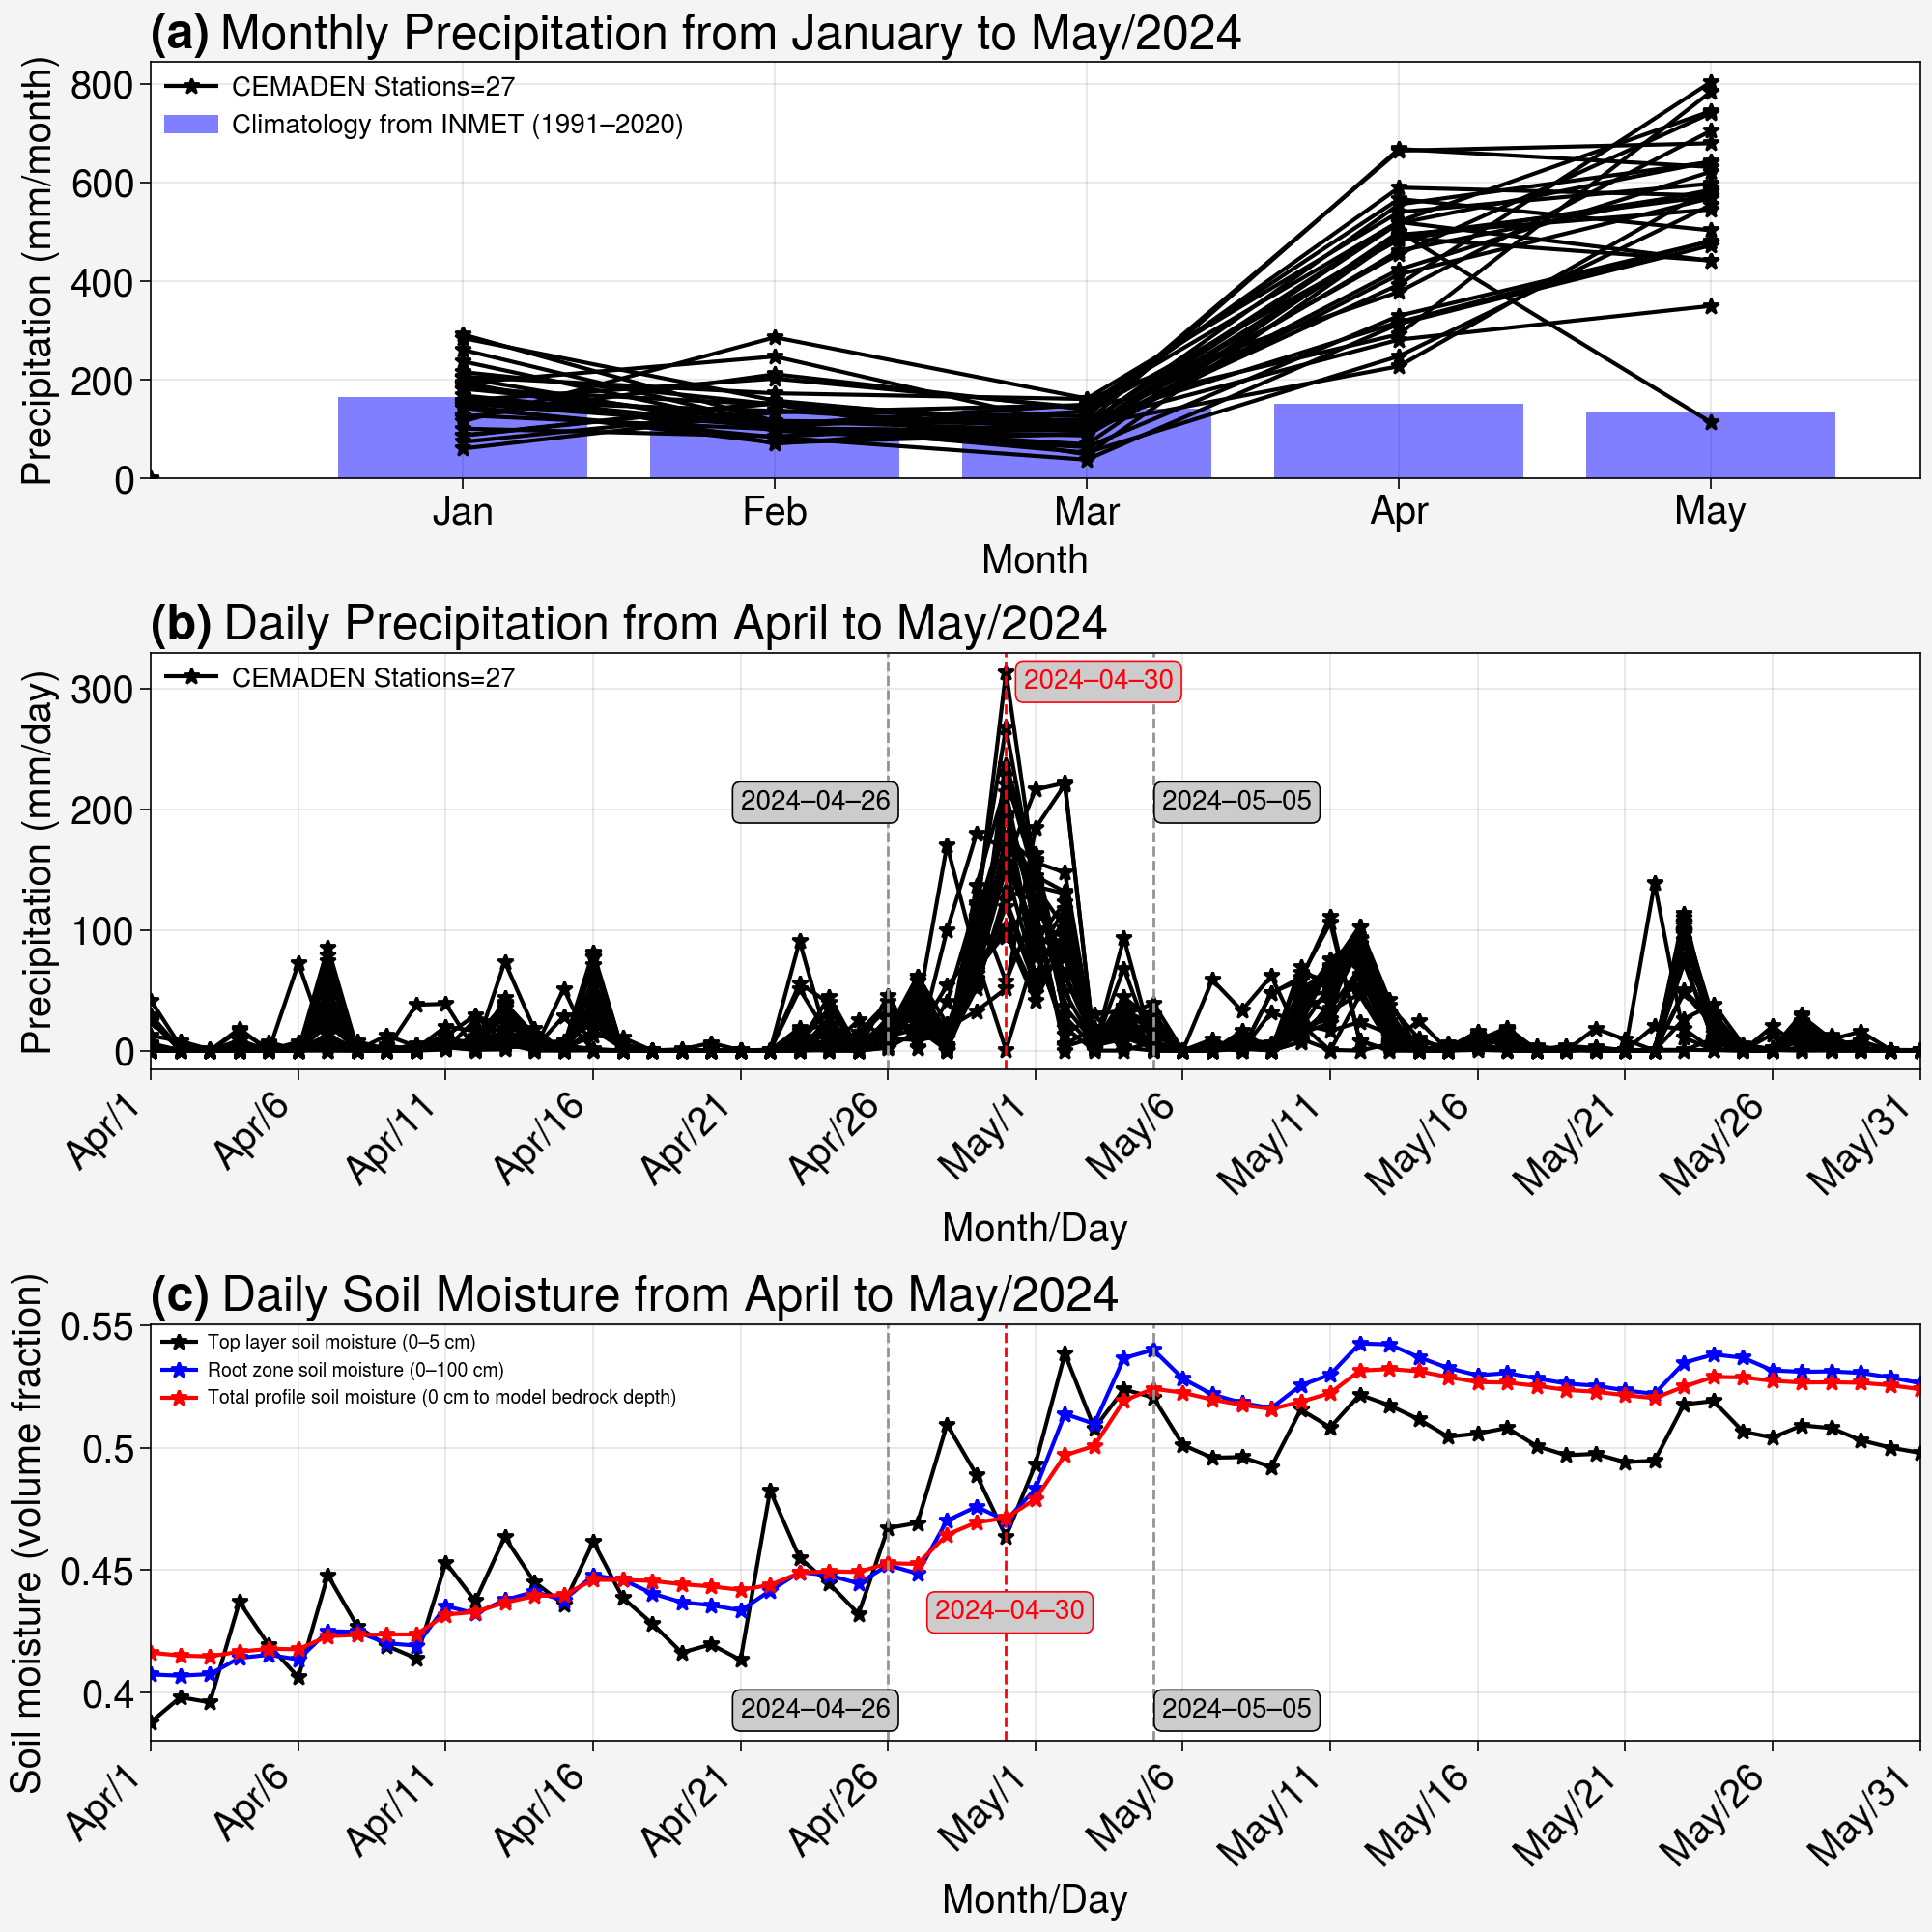

227.6 449.28666666666663 667.6
114.0 571.8203703703704 803.2
CPU times: total: 2.14 s
Wall time: 2.89 s


In [17]:
%%time
#=====================================================================================================================#
#                                      DADOS UMIDADE DO SOLO (SMAP)
#=====================================================================================================================#
codigo_estacoes_escolhidas2 = df_localizacao2['codigo'].unique().tolist()
municipio_estacoes_escolhidas2 = df_localizacao2['municipio'].unique().tolist()

# dados smap
# leitura série temporal smap. Essa planilha foi gerada no GEE, o código esta no Google Drive.
df_smap = pd.read_csv('dados_smap/SPL4SMGP_007_SMAP_L4_smap_horaria.csv')

# insere a coluna data como DateTime no DataFrame
df_smap['date'] = pd.to_datetime(df_smap['date'])

# seta a coluna data com o index do dataframe
df_smap.set_index('date', inplace=True)

# agrupa de horária para diária
df_smap_diaria = df_smap.groupby(pd.Grouper(freq='1D')).max()

#=====================================================================================================================#
#                                              FORMATAÇÃO DO GRÁFICO
#=====================================================================================================================#
# cores das curvas das estações no gráfico
cor = ['black', 'gray', 'blue', 'green', 'orange', 'red', 'magenta']

# cria moldura da figura
fig, ax = pplt.subplots(figsize=(10, 10), ncols=1, nrows=3, sharey=False, sharex=False, tight=True)

# formatação dos eixos X e Y
ax.format(abc=True,
          abcstyle='(a)',
          abcsize=5,
          small='20px',
          large='25px',
          xticks=2,
          xtickminor=False,
          ytickminor=False,
          xrotation=0)

#=====================================================================================================================#
#                                           FIG-1: MENSAL - PLUVIÔMETRO
#=====================================================================================================================#
# gráfico de barras da normal climatológica
ax[0].bar(pplt.arange(1, 5, 1), df_normal_merge.T.values, color='blue', alpha=0.5, label='Climatology from INMET (1991–2020)')

# loop das estações escolhidas
abril, maio = [], []
for municipio, codigo in zip(municipio_estacoes_escolhidas2, codigo_estacoes_escolhidas2):

    # tabela daquela estação
    df_estacao = df_top30[ df_top30['codEstacao'] == codigo]

    # faz agrupamento por mês
    df_agrupado1 = df_estacao['chuva'].groupby(pd.Grouper(freq='1M')).sum()

    # total de chuva para o mês todo para uma determinada estação
    tot_chuva = df_agrupado1.sum()

    #print(municipio, df_agrupado1.iloc[-2:].tolist())

    # coloca os valores de april e maio numa lista
    abril.append(df_agrupado1.iloc[-2])
    maio.append(df_agrupado1.iloc[-1])
    #print('-------------------------------------','\n')

    # plota gráfico
    ax[0].plot(df_agrupado1.index.month,
               df_agrupado1.values,
               color='black',
               marker='*')

# Gambiarra para plotar a legenda de apenas 1 estação do cemaden
ax[0].plot(0,0, color='black', marker='*', label=f'CEMADEN Stations={len(municipio_estacoes_escolhidas2)}')

# formatações
ax[0].format(ltitle='Monthly Precipitation from January to May/2024',
             xlabel='Month',
             ylabel='Precipitation (mm/month)',
             xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May'],
             xticks=pplt.arange(1, 5, 1),
             xtickminor=False,
             ytickminor=False)

# legenda
ax[0].legend(loc='best', ncols=1, frameon=False, prop={'size':10})

#=====================================================================================================================#
#                                     FIG-2: DIÁRIA - PLUVIÔMETRO
#=====================================================================================================================#
# loop das estações escolhidas
for municipio, codigo in zip(municipio_estacoes_escolhidas2, codigo_estacoes_escolhidas2):

    # seleciona os dados de abril e junho
    df_top30_abril_maio = df_top30.loc['2024-04-01':'2024-05-31']
        
    # tabela daquela estação
    df_estacao = df_top30_abril_maio[ df_top30_abril_maio['codEstacao'] == codigo]
    
    # faz agrupamento
    df_agrupado = df_estacao['chuva'].groupby(pd.Grouper(freq='1D')).sum()

    # total de chuva para o mês todo para uma determinada estação
    tot_chuva = df_agrupado.sum()

    # plota gráfico
    mes, dia, valores = df_agrupado.index.month.tolist(), df_agrupado.index.day.tolist(), df_agrupado.values.tolist()
    
    mes_dia =  [f'Apr/{diai}' if mesi==4 else f'May/{diai}' for mesi, diai in zip(mes, dia)]
    
    ax[1].plot(mes_dia,
               valores,
               color='black',
               marker='*')
    
# Gambiarra para plotar a legenda de apenas 1 estação do cemaden
ax[1].plot(0,0, color='black', marker='*', label=f'CEMADEN Stations={len(municipio_estacoes_escolhidas2)}')

# formatação dos eixos
ax[1].format(ltitle='Daily Precipitation from April to May/2024',
             ylabel='Precipitation (mm/day)',
             xlabel='Month/Day',
             xrotation=45,
             xticks=pplt.arange(1-1, len(valores)+1, 5))

# legenda
ax[1].legend(loc='ul', ncols=1, frameon=False, prop={'size':10})

# linha vertical indicando o dia 26/abril e 05/maio: achar o índice df_agrupado.index[29]
ax[1].axvline(x=25, color='gray', linestyle='--', lw=1.0)
ax[1].axvline(x=34, color='gray', linestyle='--', lw=1.0)
ax[1].annotate('2024–04–26', xy=(20, 200), fontsize=10, color='black', bbox=dict(boxstyle="round", fc="0.8"))
ax[1].annotate('2024–05–05', xy=(34.3, 200), fontsize=10, color='black', bbox=dict(boxstyle="round", fc="0.8"))

# dia de máxima chuva
ax[1].axvline(x=29, color='bright red', linestyle='--', lw=1.0)
ax[1].annotate('2024–04–30', xy=(29.6, 300), fontsize=10, color='bright red', bbox=dict(boxstyle="round", fc="0.8", color='bright red'))

#=====================================================================================================================#
#                                        FIG-3: DIÁRIA - UMIDADE 
#=====================================================================================================================#
#-------------------------------------------#
#               UMIDADE
#-------------------------------------------#
mes, dia, valores = df_agrupado.index.month.tolist(), df_agrupado.index.day.tolist(), df_agrupado.values.tolist()
mes_dia =  [f'Apr/{diai}' if mesi==4 else f'May/{diai}' for mesi, diai in zip(mes, dia)]

# sm_surface
ax[2].plot(mes_dia,
           df_smap_diaria['sm_surface_MAX'].values,
           color='black',
           marker='*',
           label='Top layer soil moisture (0–5 cm)')

# sm_rootzone
ax[2].plot(mes_dia,
           df_smap_diaria['sm_rootzone_MAX'].values,
           color='blue',
           marker='*',
           label='Root zone soil moisture (0–100 cm)')

# sm_profile
ax[2].plot(mes_dia,
           df_smap_diaria['sm_profile_MAX'].values,
           color='red',
           marker='*',
           label='Total profile soil moisture (0 cm to model bedrock depth)')

# formatação dos eixos
ax[2].format(ltitle='Daily Soil Moisture from April to May/2024',
             ylabel='Soil moisture (volume fraction)',
             xlabel='Month/Day',
             xrotation=45,
             xticks=pplt.arange(1-1, len(valores)+1, 5))

# legenda
ax[2].legend(loc='ul', ncols=1, frameon=False, prop={'size':7})

# linha vertical indicando o dia 26/abril e 05/maio
ax[2].axvline(x=25, color='gray', linestyle='--', lw=1.0)
ax[2].axvline(x=34, color='gray', linestyle='--', lw=1.0)
ax[2].annotate('2024–04–26', xy=(20, 0.39), fontsize=10, color='black', bbox=dict(boxstyle="round", fc="0.8"))
ax[2].annotate('2024–05–05', xy=(34.3, 0.39), fontsize=10, color='black', bbox=dict(boxstyle="round", fc="0.8"))

# dia de máxima chuva
ax[2].axvline(x=29, color='bright red', linestyle='--', lw=1.0)
ax[2].annotate('2024–04–30', xy=(26.6, 0.43), fontsize=10, color='bright red', bbox=dict(boxstyle="round", fc="0.8", color='bright red'))
#-----------------------------------#

# salva figura
fig.save('Fig_2_chuvapor_mes_dia_hora_climatologia-proof.jpg', dpi=300)

# exibe na tela
pplt.show()

# valores da precipitação mínim,a média e máxima em ABRIL e MAIO
print(np.min(abril), np.mean(abril), np.max(abril))
print(np.min(maio), np.mean(maio), np.max(maio))

# **PARTE 4):** Comparação estações do CEMADEN x INMET

## **Lista as estações do CEMADEN e calcula a chuva entre 26/abril e 6/maio**

In [229]:
%%time
#===========================================================================================================================#
#                                               DADOS CEMADEN
#===========================================================================================================================#
# lista os arquivos
files = glob.glob('dados_estacoes/estacoes_CEMADEN_RS*csv')

# leitura dos arquivos
df = pd.DataFrame()
for file in files:

    # leitura da tabela
    df0 = pd.read_csv(file, delimiter=';', decimal=',')

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df, df0], ignore_index=True)

# renomeia os nomes das colunas
df = df.rename(columns={'valorMedida': 'chuva',
                        'datahora': 'data',
                        'nomeEstacao':'nome_estacao',
                        'latitude': 'lat',
                        'longitude':'lon'})

# insere a coluna data como DateTime no DataFrame
df['data'] = pd.to_datetime(df['data'])

# seta a coluna data com o index do dataframe
df.set_index('data', inplace=True)

# seleciona o período do evento
df_evento = df.loc['2024-04-26':'2024-05-05']

#--------------------------------------------------------------------------#
#                      SELECTIONA AS TOP30 ESTAÇÕES
#--------------------------------------------------------------------------#
# soma a chuva e seleciona as estações que possuem os maiores valores de acumulados
# de chuva entre 26/abril a 05/maio
acum = df_evento.groupby('codEstacao').sum()['chuva'].sort_values(ascending=False)[0:30]

codigo_estacoes_top30 = acum.index
valores_chuva_top30 = acum.values

# salva um arquivo com as top30 estações
df_top30 = pd.DataFrame()
codigo_estacao, municipio_estacao, nome_estacao, lat_estacao, lon_estacao, totalchuva_estacao = [], [], [], [], [], []

for codigo, chuva in zip(codigo_estacoes_top30, valores_chuva_top30):

    dfx = df[ df['codEstacao'] == codigo]

    # junta a tabela que foi lida com a anterior
    df_top30 = pd.concat([df_top30, dfx], ignore_index=False)

    # salva a lat e lon e nome da estação
    codigo_estacao.append(codigo)    
    municipio_estacao.append(dfx['municipio'][0])
    nome_estacao.append(dfx['nome_estacao'][0])
    lat_estacao.append(dfx['lat'][0])
    lon_estacao.append(dfx['lon'][0])
    totalchuva_estacao.append(chuva)

# salva tabela com a localização das estações
df_info_cemaden = pd.DataFrame({'codigo_cemaden': codigo_estacao,
                                'cidade_cemaden': municipio_estacao,
                                'nome_estacao_cemaden': nome_estacao,
                                'lat_cemaden': lat_estacao,
                                'lon_cemaden': lon_estacao,
                                'chuva_cemaden': totalchuva_estacao})

# elimina linhas duplicadas e mantem a primeira ocorrência
df_info_cemaden.drop_duplicates(subset=['cidade_cemaden'], keep='first', inplace=True)

# salva tabela 
df_info_cemaden['cidade_cemaden'] = df_info_cemaden['cidade_cemaden'].apply(lambda x: x.title())

# mostra tabela
display(df_info_cemaden)

,codigo_cemaden,cidade_cemaden,nome_estacao_cemaden,lat_cemaden,lon_cemaden,chuva_cemaden
0,432026301A,Segredo,Prefeitura,-29.339900,-52.982000,812.60
1,430830001A,Fontoura Xavier,Centro,-28.984850,-52.344450,778.00
2,431123901A,Lagoa Bonita Do Sul,Centro,-29.490000,-53.013000,749.20
3,430510802A,Caxias Do Sul,Forqueta,-29.214000,-51.282000,679.60
4,430420002A,Candelária,Fábrica de Injetados,-29.662860,-52.787290,666.80
5,431310201A,Nova Palma,Centro,-29.470000,-53.465000,636.80
6,430800301A,Faxinal Do Soturno,Centro,-29.580900,-53.446700,634.80
7,432080002A,Soledade,Centro,-28.830164,-52.510442,624.80
8,430057001A,Alto Feliz,Alto Feliz,-29.382020,-51.317580,617.00
9,431140303A,Lajeado,Moinhos D´Agua,-29.452000,-52.003000,589.40


CPU times: total: 1.7 s
Wall time: 2.82 s


## **Lista as estações do INMET**

In [230]:
# lista as estações do RS
files = glob.glob('dados_estacoes/ESTACOES_inmet_2024/INMET_S_RS_*')

# loop dos arquivos
cidade, codigo, lat, lon = [], [], [], []
for file in files:
    
    # leitura da tabela, apenas do cabeçalho das estações. Faz a leitura apenas do cabeçalho dos dados
    df = pd.read_csv(file, encoding='iso-8859-1', nrows=7,  decimal=',', delimiter=';')

    # extrai as informações
    cidade.append(df.iloc[1][1])
    codigo.append(df.iloc[2][1])
    lat.append(df.iloc[3][1].replace(',', '.'))
    lon.append(df.iloc[4][1].replace(',', '.'))

# coloca num dataframe
df_info_inmet = pd.DataFrame({'cidade': cidade,
                              'codigo': codigo,
                              'Latitude': lat,
                              'Longitude': lon})
df_info_inmet['Latitude'] = df_info_inmet['Latitude'].astype(float)
df_info_inmet['Longitude'] = df_info_inmet['Longitude'].astype(float)

# mostra os dados
#display(df_info_inmet)

## **Compara tabela CEMADEN x INMET**: encontra a estação do INMET mais próxima da estação do CEMADEN

In [231]:
df_info_inmet

,cidade,codigo,Latitude,Longitude
0,PORTO ALEGRE - JARDIM BOTANICO,A801,-30.053611,-51.174722
1,RIO GRANDE,A802,-32.078889,-52.167778
2,SANTA MARIA,A803,-29.725000,-53.720556
3,SANTANA DO LIVRAMENTO,A804,-30.750556,-55.401389
4,SANTO AUGUSTO,A805,-27.854444,-53.791111
5,TORRES,A808,-29.350278,-49.733333
6,URUGUAIANA,A809,-29.840000,-57.081944
7,SANTA ROSA,A810,-27.890556,-54.480000
8,CANGUCU,A811,-31.403333,-52.700833
9,CACAPAVA DO SUL,A812,-30.545278,-53.466944


In [232]:
df_info_cemaden

,codigo_cemaden,cidade_cemaden,nome_estacao_cemaden,lat_cemaden,lon_cemaden,chuva_cemaden
0,432026301A,Segredo,Prefeitura,-29.339900,-52.982000,812.60
1,430830001A,Fontoura Xavier,Centro,-28.984850,-52.344450,778.00
2,431123901A,Lagoa Bonita Do Sul,Centro,-29.490000,-53.013000,749.20
3,430510802A,Caxias Do Sul,Forqueta,-29.214000,-51.282000,679.60
4,430420002A,Candelária,Fábrica de Injetados,-29.662860,-52.787290,666.80
5,431310201A,Nova Palma,Centro,-29.470000,-53.465000,636.80
6,430800301A,Faxinal Do Soturno,Centro,-29.580900,-53.446700,634.80
7,432080002A,Soledade,Centro,-28.830164,-52.510442,624.80
8,430057001A,Alto Feliz,Alto Feliz,-29.382020,-51.317580,617.00
9,431140303A,Lajeado,Moinhos D´Agua,-29.452000,-52.003000,589.40


In [243]:
# monta uma cópia da tabela do cemaden
df_info_cemaden_inmet = df_info_cemaden.copy()

df_info_cemaden_inmet['codigo_inmet']=0
df_info_cemaden_inmet['cidade_inmet']=0
df_info_cemaden_inmet['lat_inmet']=0
df_info_cemaden_inmet['lon_inmet']=0
df_info_cemaden_inmet['chuva_inmet']=0
df_info_cemaden_inmet['distancia_inmet']=0

# Loop das estações do CEMADEN
for i, linha in enumerate(df_info_cemaden.itertuples()):

    #--------------------------------------------------------------------#
    #                Extrai os dados da tabela do CEMADEN
    #--------------------------------------------------------------------#
    lat_cemaden, lon_cemaden = linha.lat_cemaden, linha.lon_cemaden 

    #--------------------------------------------------------------------#
    #                  Calcula a distância
    #--------------------------------------------------------------------#
    dis = (np.sqrt( (df_info_inmet['Latitude'].values - float(lat_cemaden))**2 +  (df_info_inmet['Longitude'].values - float(lon_cemaden))**2 ) ) * 111.195

    distancias = dis.tolist()
    distancia_min = np.min(distancias)
    indice = distancias.index(distancia_min)
   
    #--------------------------------------------------------------------#
    #       Monta a coluna de alguns dados do INMET
    #--------------------------------------------------------------------#
    df_info_cemaden_inmet['codigo_inmet'].iloc[i] = df_info_inmet['codigo'].values[indice]
    df_info_cemaden_inmet['cidade_inmet'].iloc[i] = df_info_inmet['cidade'].values[indice]
    df_info_cemaden_inmet['lat_inmet'].iloc[i] = df_info_inmet['Latitude'].values[indice]
    df_info_cemaden_inmet['lon_inmet'].iloc[i] = df_info_inmet['Longitude'].values[indice]
    df_info_cemaden_inmet['distancia_inmet'].iloc[i] = distancia_min

    #--------------------------------------------------------------------#
    #                  Computa a chuva do INMET
    #--------------------------------------------------------------------#
    # encontra o arquivo
    file_inmet = glob.glob(f"dados_estacoes/ESTACOES_inmet_2024\\INMET_S_RS_{df_info_cemaden_inmet['codigo_inmet'].iloc[i]}*")
    file_inmet = file_inmet[0]
    
    # leitura da tabela
    dados_inmet = pd.read_csv(file_inmet, encoding='iso-8859-1', decimal=',', delimiter=';', skiprows=8)

    # renomeia os nomes das colunas
    dados_inmet = dados_inmet.rename(columns={'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'chuva', 'Data': 'data'})

    # insere a coluna data como DateTime no DataFrame
    dados_inmet['data'] = pd.to_datetime(dados_inmet['data'])

    # seta a coluna data com o index do dataframe
    dados_inmet.set_index('data', inplace=True)

    # seleciona o período do evento
    dados_inmet_evento = dados_inmet.loc['2024-04-26':'2024-05-05']

    # soma e insere a chuva na tabela
    df_info_cemaden_inmet['chuva_inmet'].iloc[i] = dados_inmet_evento['chuva'].sum()

# reorganiza o dataframe
df_info_cemaden_inmet = df_info_cemaden_inmet[['codigo_cemaden', 'cidade_cemaden', 'nome_estacao_cemaden', 'lat_cemaden',
                                               'codigo_inmet', 'cidade_inmet', 'lat_inmet', 'lon_inmet', 'distancia_inmet', 
                                               'chuva_cemaden', 'chuva_inmet']]

# calcula a diferença entre a chuva do CEMADEN e INMET
df_info_cemaden_inmet['dif_cemaden_inmet'] = df_info_cemaden_inmet['chuva_cemaden'] - df_info_cemaden_inmet['chuva_inmet'] 

# calcula a diferença relativa (em %) entre a chuva do CEMADEN e INMET
df_info_cemaden_inmet['dif_cemaden_inmet_porc'] = ((df_info_cemaden_inmet['chuva_cemaden'] - df_info_cemaden_inmet['chuva_inmet']) / df_info_cemaden_inmet['chuva_inmet'])*100.

# coloca os valores em ordem descrecente
df_info_cemaden_inmet.sort_values('distancia_inmet', inplace=True, ignore_index=True)

# coloca os valores em ordem descrecente
df_info_cemaden_inmet.to_csv('dados_estacoes/comparacao_CEMADEN_INMET.csv')

# mostra na tela
display(df_info_cemaden_inmet)

,codigo_cemaden,cidade_cemaden,nome_estacao_cemaden,lat_cemaden,codigo_inmet,cidade_inmet,lat_inmet,lon_inmet,distancia_inmet,chuva_cemaden,chuva_inmet,dif_cemaden_inmet,dif_cemaden_inmet_porc
0,432145101A,Teutônia,Teutônia,-29.452400,A882,TEUTONIA,-29.449167,-51.823333,1.558008,502.00,295.0,207.00,70.169492
1,432080002A,Soledade,Centro,-28.830164,A837,SOLEDADE,-28.859211,-52.542387,4.801012,624.80,610.2,14.60,2.392658
2,432040401A,Serafina Corrêa,Centro,-28.710219,A894,SERAFINA CORREA,-28.704722,-51.870833,6.587109,419.00,512.2,-93.20,-18.196017
3,431690707A,Santa Maria,Lorenzi,-29.727000,A803,SANTA MARIA,-29.725000,-53.720556,9.614764,553.40,502.0,51.40,10.239044
4,432300205A,Viamão,Vila Augusta,-30.048000,A801,PORTO ALEGRE - JARDIM BOTANICO,-30.053611,-51.174722,10.107132,427.00,384.8,42.20,10.966736
5,430460605A,Canoas,Marechal Rondon,-29.924000,A801,PORTO ALEGRE - JARDIM BOTANICO,-30.053611,-51.174722,14.421670,423.40,384.8,38.60,10.031185
6,430780702A,Estrela,Industrias,-29.482400,A882,TEUTONIA,-29.449167,-51.823333,16.581082,442.60,295.0,147.60,50.033898
7,432170906H,Três Coroas,Rio Paranhana,-29.515670,A879,CANELA,-29.368889,-50.827222,17.354321,486.00,569.4,-83.40,-14.646997
8,430620501A,Cruzeiro Do Sul,Secretaria da Agricultura,-29.513220,A882,TEUTONIA,-29.449167,-51.823333,19.317480,473.20,295.0,178.20,60.406780
9,431140303A,Lajeado,Moinhos D´Agua,-29.452000,A882,TEUTONIA,-29.449167,-51.823333,19.980521,589.40,295.0,294.40,99.796610
